In [1]:
import pandas as pd
from dython.nominal import associations
from sklearn.cluster import DBSCAN

from gower.gower_dist import *

# Simple example from D'Orazio

In [2]:
df = pd.DataFrame({"Sex1": ["M", "M", "F", "F", "F", "M", "M", "F", "F", "F"],
                   "Sex2": ["M", "M", "F", "F", "F", "F", "F", "M", "M", "M"],
                   "Age1": [15] * 10,
                   "Age2": [15, 36, 58, 78, 100, 15, 36, 58, 78, 100]})

In [3]:
distances = np.diag(gower_matrix(df[["Sex1", "Age1"]].to_numpy(), df[["Sex2", "Age2"]].to_numpy()))
print(distances)
df.loc[np.argsort(distances)]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0.49131427] [1.1832003]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.17457004 0.35745294 0.52371012 0.70659301 0.29340699
 0.46797702 0.65085992 0.8171171  1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
1,M,M,15,36
5,M,F,15,15
2,F,F,15,58
6,M,F,15,36
3,F,F,15,78
7,F,M,15,58
4,F,F,15,100
8,F,M,15,78
9,F,M,15,100


# Metrics

### We can also use the categorical weight function to measure cluster quality and thereby tune clustering algorithms such as DBSCAN.

##### I calculated Gower distances for each of the four datasets above using the new weighting scheme, and then ran a grid search with DBSCAN based on the new weighting formula for categorical variables.

# Istanbul dataset

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[0.44767737 0.68279993 0.5554082  0.7547059 ] [1.14251959 1.10217929 1.16058148 1.05438304]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.08, 'min_samples': 1}, 0.9341561621595391)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  19,  20,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  47,  48,  52,  53,  54,  55,  56,  58,  59,
        61,  63,  64,  69,  71,  73,  77,  78,  79,  80,  81,  82,  84,
        94,  98, 100, 103, 104, 110, 116, 117, 118, 120, 124, 125, 130,
       137, 142, 147, 157, 167, 178, 221, 229, 244, 294, 323]), array([272,  92,  53,  37,  16,   8,  13,   6,   3,   4,   5,   5,   3,
         4,   3,   5,   4,   4,   5,   6,   3,   3,   3,   3,   2,   3,
         2,   1,   2,   3,   4,   4,   5,   1,   1,   2,   2,   1,   4,
         1,   2,   2,   1,   4,   3,   1,   4,   1,   2,   1,   3,   1,
         2,   2,   1,   3,   1,   2,   1,   2,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   1,   1,   1,
         2,   1, 

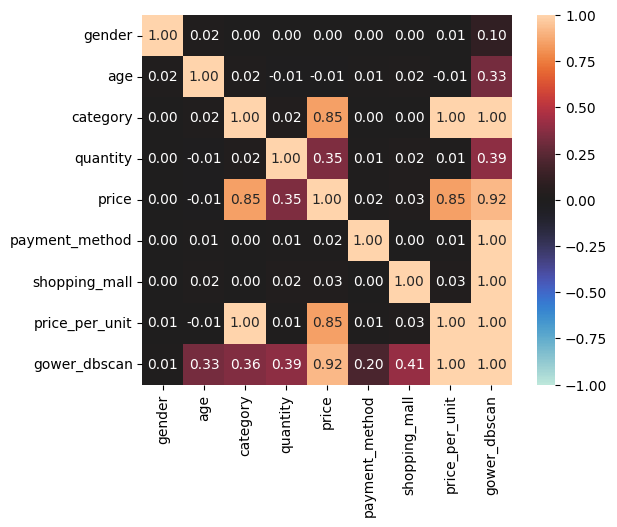

,gender,age,category,quantity,price,payment_method,shopping_mall,price_per_unit,gower_dbscan,label_count
62990,Female,21,Clothing,2,600.16,Cash,Mall of Istanbul,300.08,4,323
18989,Female,45,Clothing,2,600.16,Cash,Mall of Istanbul,300.08,4,323
6469,Female,33,Clothing,2,600.16,Cash,Mall of Istanbul,300.08,4,323
18813,Male,21,Clothing,2,600.16,Cash,Mall of Istanbul,300.08,4,323
29043,Female,36,Clothing,2,600.16,Cash,Mall of Istanbul,300.08,4,323
...,...,...,...,...,...,...,...,...,...,...
65113,Male,25,Souvenir,5,58.65,Cash,Metrocity,11.73,665,1
11811,Female,38,Books,2,30.30,Credit Card,Forum Istanbul,15.15,666,1
63670,Female,25,Toys,3,107.52,Debit Card,Emaar Square Mall,35.84,667,1
70056,Male,43,Technology,3,3150.00,Debit Card,Zorlu Center,1050.00,85,1


In [4]:
istanbul = pd.read_csv("customer_shopping_data.csv").sample(n=10000, random_state=0).iloc[:, 2:]  # no nulls!
istanbul["price_per_unit"] = istanbul["price"] / istanbul["quantity"]
istanbul.drop("invoice_date", axis=1, inplace=True)

matrix4 = gower_matrix(istanbul.to_numpy(), chunksize=20)

samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]

results4 = process_map(partial(evaluate_clusters, matrix=matrix4), samples, chunksize=1)

best_params4 = max(results4, key=lambda z: z[1])

print(best_params4)

istanbul["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params4[0]).fit_predict(matrix4)
istanbul.gower_dbscan = istanbul.gower_dbscan.astype(str)

_, counts4 = np.unique(istanbul["gower_dbscan"], return_counts=True)

print(np.unique(counts4, return_counts=True))

associations(istanbul, nom_nom_assoc="theil", plot=True)

istanbul["label_count"] = istanbul.groupby("gower_dbscan").transform("count").iloc[:, 0]

istanbul.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

istanbul


# Laptops dataset

(977, 12)
Model Name                  488
Category                      6
Screen Size                  18
Screen                       38
CPU                         106
RAM                           8
 Storage                     36
GPU                          98
Operating System              7
Operating System Version      5
Weight                      166
Price                       639
dtype: int64


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0.52904454 0.57489035 0.63886396 0.81719039 0.54905507 0.70013661
 0.79481196 0.3021191  0.8961077 ] [1.32098757]


  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.206, 'min_samples': 1}, 0.6818887378044342)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  13,  15,  28,
        34,  52, 160]), array([354,  52,  17,   6,   8,   2,   3,   5,   2,   1,   1,   1,   1,
         1,   1,   1]))


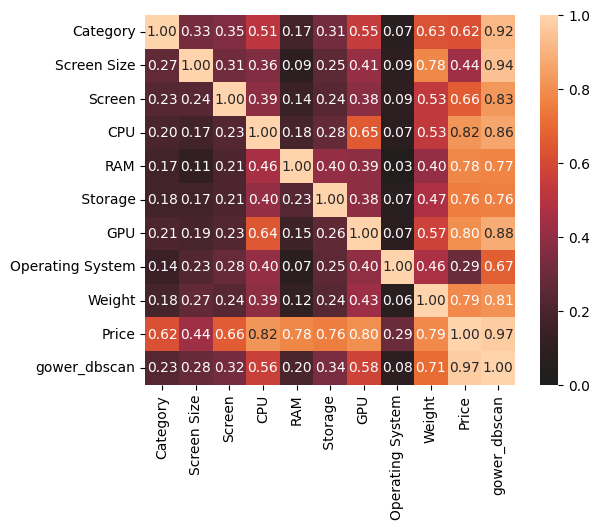

,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Weight,Price,gower_dbscan,label_count
Manufacturer,,,,,,,,,,,,
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,5112900.00,2,160
Acer,Notebook,"15.6""",1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows,2.1kg,3556800.00,2,160
HP,Notebook,"15.6""",1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,3502558.80,2,160
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,3067651.08,2,160
Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows,2.2kg,4436218.80,2,160
...,...,...,...,...,...,...,...,...,...,...,...,...
Lenovo,2 in 1 Convertible,"14.0""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i3 7100U 2.4GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows,1.74kg,5593068.00,91,1
Dell,2 in 1 Convertible,"15.6""",Full HD / Touchscreen 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows,1.56kg,9327708.00,93,1
Huawei,Ultrabook,"13.0""",IPS Panel Full HD 2160x1440,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.05kg,11995308.00,97,1


In [5]:
laptops = pd.read_csv("laptops/laptops_train.csv", index_col=0)
print(laptops.shape)
print(laptops.apply(lambda col: col.unique(), axis=0).apply(len))
laptops.drop(["Operating System Version", "Model Name"], axis=1, inplace=True)

matrix3 = gower_matrix(laptops.to_numpy(), chunksize=20)
samples = [{"eps": z / 1000, "min_samples": 1} for z in range(1, 1001)]
results3 = process_map(partial(evaluate_clusters, matrix=matrix3), samples, chunksize=20)
best_params3 = max(results3, key=lambda z: z[1])
print(best_params3)
laptops["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params3[0]).fit_predict(matrix3)
laptops.gower_dbscan = laptops.gower_dbscan.astype(str)
_, counts3 = np.unique(laptops["gower_dbscan"], return_counts=True)
print(np.unique(counts3, return_counts=True))

associations(laptops, nom_nom_assoc="theil", plot=True)

laptops["label_count"] = laptops.groupby("gower_dbscan").transform("count").iloc[:, 0]
laptops.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

laptops


# Pokemon dataset

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[0.82174784 0.60714457 0.17869839 0.78097485 0.23119995 0.77037748
 0.44453337 0.17869839 0.75525083] [1.26206238 1.32698996 1.30349832 1.32226421 1.3512904  1.28645772
 1.32751754 1.16328871 1.43984775 1.24708686 1.19489936 1.62051258]


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.12, 'min_samples': 1}, 0.670791574375545)
(array([  1,   2,   3,   4,   5,   6,   7,   9,  12,  15,  20,  31,  33,
       165]), array([229,  59,  10,   6,   3,   1,   2,   1,   1,   1,   1,   1,   1,
         1]))


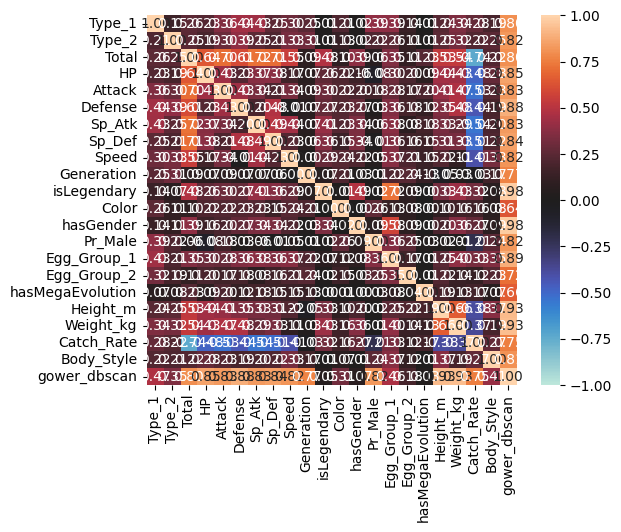

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,...,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,gower_dbscan,label_count
0,Grass,Poison,318,45,49,49,65,65,45,1,...,0.875,Monster,Grass,False,0.71,6.9,45,quadruped,0,165
1,Grass,Poison,405,60,62,63,80,80,60,1,...,0.875,Monster,Grass,False,0.99,13.0,45,quadruped,0,165
2,Grass,Poison,525,80,82,83,100,100,80,1,...,0.875,Monster,Grass,True,2.01,100.0,45,quadruped,0,165
3,Fire,none,309,39,52,43,60,50,65,1,...,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed,0,165
4,Fire,none,405,58,64,58,80,65,80,1,...,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed,0,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Ice,Flying,330,45,55,45,65,45,75,2,...,0.500,Water_1,Field,False,0.89,16.0,45,two_wings,94,1
225,Water,Flying,465,65,40,70,80,140,70,2,...,0.500,Water_1,none,False,2.11,220.0,25,two_wings,95,1
226,Steel,Flying,465,65,80,140,40,70,70,2,...,0.500,Flying,none,False,1.70,50.5,25,two_wings,96,1
235,Fighting,none,210,35,35,35,35,35,35,2,...,1.000,Undiscovered,none,False,0.71,21.0,75,bipedal_tailless,98,1


In [6]:
pokemon = pd.read_csv("pokemon/pokemon_alopez247.csv").iloc[:, 2:]
for c in pokemon.columns[pokemon.dtypes != object]:
    pokemon.loc[pokemon[c].isna(), c] = np.nanmedian(pokemon[c])
for c in pokemon.columns[pokemon.dtypes == object]:
    pokemon.loc[pokemon[c].isna(), c] = "none"

matrix2 = gower_matrix(pokemon.to_numpy(), chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 1001)]
results2 = process_map(partial(evaluate_clusters, matrix=matrix2), samples, chunksize=20)
best_params2 = max(results2, key=lambda z: z[1])
print(best_params2)
pokemon["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params2[0]).fit_predict(matrix2)
pokemon.gower_dbscan = pokemon.gower_dbscan.astype(str)
_, counts2 = np.unique(pokemon["gower_dbscan"], return_counts=True)
print(np.unique(counts2, return_counts=True))

associations(pokemon, nom_nom_assoc="theil", plot=True)

pokemon["label_count"] = pokemon.groupby("gower_dbscan").transform("count").iloc[:, 0]
pokemon.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

pokemon


# Dog adoption dataset

breed_secondary
color_primary
color_secondary
color_tertiary
declawed
env_cats


  0%|          | 0/28 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[0.97604874 0.86586598 0.         0.         0.85943127 0.35785068
 0.         0.59033722 0.4964133  0.51431603 0.37258288 0.25816832
 0.46793647 0.1624974  0.18125111 0.26942076 0.23138547 0.93778805
 0.         0.86590699 0.97478917 0.89110272 0.97659407 0.0104529
 0.84734244 0.         0.         0.87101594] []


  0%|          | 0/13729 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.49, 'min_samples': 1}, 0.9313058141121292)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  53,  54,  55,  58,
        60,  61,  63,  65,  69,  70,  71,  73,  79,  82,  84,  92, 101,
       102, 103, 132, 141, 145, 154, 407]), array([775, 303, 164, 139, 102,  75,  64,  40,  53,  31,  38,  33,  29,
        20,  13,  15,  14,   9,  14,  13,  11,  10,   7,   3,   7,   3,
         5,   5,   3,   4,   5,   4,   1,   1,   7,   2,   1,   3,   5,
         4,   2,   1,   1,   2,   2,   3,   1,   1,   2,   1,   1,   1,
         1,   2,   1,   1,   2,   1,   2,   2,   1,   2,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1]))


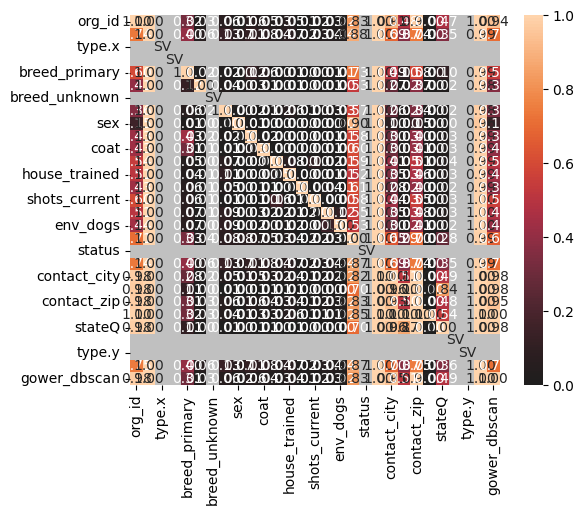

,org_id,url,type.x,species,breed_primary,breed_mixed,breed_unknown,age,sex,size,...,contact_city,contact_state,contact_zip,contact_country,stateQ,accessed,type.y,description,gower_dbscan,label_count
id,,,,,,,,,,,,,,,,,,,,,
46021535,TX2394,https://www.petfinder.com/dog/brody-bear-46021...,Dog,Dog,Schnauzer,True,False,Baby,Male,Small,...,Brattleboro,VT,05301,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Brody! ...,243,407
46021378,TX2394,https://www.petfinder.com/dog/brody-46021378/c...,Dog,Dog,Schnauzer,True,False,Baby,Male,Small,...,Groton,CT,06340,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Brody! ...,243,407
46021361,TX2394,https://www.petfinder.com/dog/daisey-may-46021...,Dog,Dog,Weimaraner,True,False,Young,Female,Medium,...,Brattleboro,VT,05301,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Daisey M...,243,407
46021331,TX2394,https://www.petfinder.com/dog/daisey-mae-46021...,Dog,Dog,Weimaraner,True,False,Young,Female,Medium,...,Boston,MA,02128,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Daisey M...,243,407
46021276,TX2394,https://www.petfinder.com/dog/daisey-mae-3-460...,Dog,Dog,Weimaraner,True,False,Young,Female,Medium,...,Groton,CT,06340,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Daisey M...,243,407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44176644,ID28,https://www.petfinder.com/dog/max-44176644/id/...,Dog,Dog,Rottweiler,True,False,Adult,Male,Large,...,McCall,ID,83638,US,ID,2019-09-20,Dog,\nIntroducing Max! Max is a really funny guy w...,972,1
46012978,IL181,https://www.petfinder.com/dog/gus-46012978/il/...,Dog,Dog,Black Labrador Retriever,False,False,Adult,Male,Large,...,Springfield,IL,62703,US,IL,2019-09-20,Dog,"This sweet boy was brought in for adoption, he...",977,1
45849734,IL435,https://www.petfinder.com/dog/avery-45849734/i...,Dog,Dog,Black Labrador Retriever,True,False,Young,Female,Medium,...,Lincoln,IL,62656,US,IL,2019-09-20,Dog,Avery is a beautiful young black lab who is lo...,991,1


In [7]:
dd = pd.read_csv("dog_adoption/allDogDescriptions.csv", index_col=0)
dd.set_index("id", inplace=True, drop=True)


# get rid of columns with the most destructive nans

def isolate_nans(column):
    all_other_nans = nans[[c for c in cols if c != column]].sum(axis=1)
    mask = all_other_nans < np.median(all_other_nans)
    mask &= nans[column]
    return mask.sum()


nans = dd.isna()
cols = dd.columns
isolated_nans = {c: isolate_nans(c) for c in cols}
median_count = np.median([v for v in isolated_nans.values() if v > 0])
for column, count in isolated_nans.items():
    if count > median_count:
        print(column)
        dd.drop(column, axis=1, inplace=True)
dd.dropna(inplace=True)  # dd.mode().iloc[0]

# make bools strings
is_bool = dd.dtypes == bool
dd.loc[:, is_bool] = dd[dd.columns[is_bool]].astype(str)

matrix = gower_matrix(dd.to_numpy(), chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]
results = process_map(partial(evaluate_clusters, matrix=matrix), samples, chunksize=1)
best_params = max(results, key=lambda z: z[1])
print(best_params)
dd["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params[0]).fit_predict(matrix)
dd.gower_dbscan = dd.gower_dbscan.astype(str)
_, counts = np.unique(dd["gower_dbscan"], return_counts=True)
print(np.unique(counts, return_counts=True))

associations(dd, nom_nom_assoc="theil", plot=True)

dd["label_count"] = dd.groupby("gower_dbscan").transform("count").iloc[:, 0]
dd.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

dd
